In [1]:
import xclim
import xarray as xr
import cftime
import xclim.sdba as sdba
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns


from xclim.sdba.base import Grouper
from xarray.coding.times import decode_cf_datetime

In [2]:
lat_min, lat_max = 55.38, 56.01
lon_min, lon_max = 8.15, 9.97

In [ ]:
observations = xr.open_dataset('O:\\Public\\sharing-4270-CERM\\MATNEW\\Era5-Land\\Hourly_Data\\Precipitation\\era5_land_1950_2024_tp_daily_update_DK_regridCORDEX.nc')[["tp"]]
observations = observations.rename({"tp": "pr"})
observations['pr'] = observations['pr'] *1000
observations['time'] = pd.to_datetime(observations['time'].values).normalize()

select_subset= (
    (observations['lat'] >= lat_min) & (observations['lat'] <= lat_max) &
    (observations['lon'] >= lon_min) & (observations['lon'] <= lon_max)
)

observations = observations.where(select_subset).dropna(dim="y", how="all").dropna(dim="x", how="all")

In [ ]:
observations.pr.sel(time='1950-01-02').plot()

In [ ]:
#Select period for calibration in observational time series
obs_calib = observations['pr'].sel(time=slice("1981-01-01", "2010-12-31"))

#Remove leap days 
#Create leap day mask
not_leap_day = ~((obs_calib['time'].dt.month == 2) & (obs_calib['time'].dt.day == 29))

# Apply the mask
obs_calib = obs_calib.sel(time=not_leap_day)

In [ ]:
obs_calib

In [ ]:
#Create mask to match pixels between datasets
mask = xr.where(observations.sel(time='1981-01-01').notnull(), 1, 0)

In [ ]:
mask.pr.plot()

In [ ]:
all_pr_model_files = glob.glob("O:\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\pr\\raw_cordex\\raw cordex\\*.nc")
forced_model_files = glob.glob("O:\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\pr\\raw_cordex\\raw cordex\\*rcp85*.nc")

In [ ]:
forced_model_names = [file.split("pr_")[1].split("_v")[0] for file in forced_model_files]

In [ ]:
unique_model_names = sorted(list(set(forced_model_names)))

In [ ]:
unique_model_names

In [736]:
len(unique_model_names)

72

In [738]:
# Paths
output_dir = "O:\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\new_bc\\"

In [812]:
%%time
for model in list(unique_model_names)[4:]:
    pr_model_files = [file for file in all_pr_model_files if f"pr_{model}_" in file]

    # Construct the historical model name by replacing "rcp85" with "historical"
    historical_models = model.replace("rcp85", "historical")

    # Grab files that match this model but with "historical"
    pr_historical_files = [file for file in all_pr_model_files if historical_models in file]

    # Combine both sets of files
    pr_model_files_filtered = pr_model_files + pr_historical_files

    print(f"Processing {model} with {len(pr_model_files_filtered)} pr files...") 

    #Grab model data
    datasets = [xr.open_dataset(f) for f in pr_model_files_filtered]
    model_daily = xr.concat(datasets, dim='time')
    #model_daily = xr.open_mfdataset(pr_model_files_filtered, combine='by_coords', engine='netcdf4').compute()
    print("Successfuly opened xarray dataset.")

    #convert from flux to mm/day
    model_daily['pr'] = model_daily['pr']*86400

    calendar = model_daily['time'].encoding.get('calendar', 'standard')

    if calendar in ['360_day']:
        print(f"Non-Gregorian calendar detected ({calendar}), skipping datetime64 conversion.")
        continue

    if 'XTIME' in model_daily.coords and 'time' not in model_daily.coords:
        print(f"XTIME detected, skipping datetime64 conversion.")
        continue

    #convert from cftime (need fail safe here)
    try:
        if not isinstance(model_daily.indexes['time'], pd.DatetimeIndex):
            model_daily['time'] = model_daily.indexes['time'].to_datetimeindex()
    except Exception as e:
        print(f"Time index conversion failed: {e}")

    model_daily['time'] = pd.to_datetime(model_daily['time'].values).normalize()
    model_daily = model_daily.sortby('time')

    not_leap_day = ~((model_daily['time'].dt.month == 2) & (model_daily['time'].dt.day == 29))
    model_daily = model_daily.sel(time=not_leap_day)
    
    model_daily = model_daily.where(select_subset).dropna(dim="y", how="all").dropna(dim="x", how="all")
    
    #Mask the model data
    mask_expanded_model = mask.expand_dims(time=model_daily.time)
    model_daily = model_daily.where(mask_expanded_model).dropna(dim="y", how="all").dropna(dim="x", how="all")

    model_daily = model_daily +1 #Add constant to avoid infinity error
    obs_calib_adj = obs_calib +1 #Add constant to avoid infinity error

    obs_calib_adj_95 = obs_calib_adj.quantile(0.95, dim="time")
    obs_calib_adj_98 = obs_calib_adj.quantile(0.98, dim="time")

    print(f"95th percentile {obs_calib_adj_95}")
    print(f"98th percentile {obs_calib_adj_98}")

    #Select the calibration periods and period to apply bias correction
    model_calib = model_daily.sel(time=slice("1981-01-01", "2010-12-31"))['pr']
    model_bc = model_daily['pr']
    #model_daily.min()
    
    #Set the units 
    model_calib.attrs['units'] = 'mm/day'
    obs_calib_adj.attrs['units'] = 'mm/day'
    model_bc.attrs['units'] = 'mm/day'
    
    #Apply QDM bias correction 
    qdm = sdba.QuantileDeltaMapping.train(ref=obs_calib_adj, hist=model_calib, group=Grouper("time.month"), kind = '*')
    corrected_qdm = qdm.adjust(model_bc)
    
    corrected_qdm = corrected_qdm -1 
    obs_calib_adj = obs_calib_adj -1 
    model_calib = model_calib -1
    model_bc = model_bc -1 
    
    #Fix if negative values appear
    corrected_qdm.values[corrected_qdm.values <= 0.0] = 0.0
    
    corrected_qdm.attrs['units'] = 'mm/day'
    model_calib.attrs['units'] = 'mm/day'
    obs_calib_adj.attrs['units'] = 'mm/day'
    model_bc.attrs['units'] = 'mm/day'
    
    # Apply EVT (GPD) to the tails (extremes) of data
    extremes = sdba.ExtremeValues.train(ref=obs_calib_adj, hist=model_calib, q_thresh=0.95, cluster_thresh = "7.5 mm/day")
    corrected_with_extremes = extremes.adjust(sim = model_bc, scen = corrected_qdm)
    
    #Remove drizzle effect in RCM outputs 
    #corrected_with_extremes.values[corrected_with_extremes.values <= 0.5] = 0
    
    #Transpose the datarray (fix issue with BC method switching position of latitude and longitude)
    corrected_with_extremes = corrected_with_extremes.transpose("time", "y", "x")
    
    #Rename variable from 'scen' to 'pr'
    corrected_with_extremes = corrected_with_extremes.rename("pr")
    
    first_year = corrected_with_extremes['time'].dt.year.min().item()
    last_year = corrected_with_extremes['time'].dt.year.max().item()
    
    #Save final output name
    output_path = os.path.join(output_dir, f"{model}_{first_year}-{last_year}_BC_Esbjerg.nc")
    
    #Export NetCDF
    corrected_with_extremes.to_dataset().to_netcdf(output_path)

    break

Processing EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_DMI-HIRHAM5 with 2 pr files...
Successfuly opened xarray dataset.


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


95th percentile <xarray.DataArray 'pr' (y: 7, x: 9)> Size: 252B
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 10.475028 ],
       [       nan,        nan, 11.491155 , 11.318968 , 11.750774 ,
        10.945784 , 10.307256 ,  9.956943 ,  9.702505 ],
       [       nan, 11.415527 , 11.2346945, 11.286523 , 11.4908695,
        10.857656 , 10.265355 , 10.004785 ,        nan],
       [12.129974 , 11.5935955, 11.259878 , 11.258909 , 11.211693 ,
        10.991318 , 10.366734 , 10.140559 , 10.307093 ],
       [12.300949 , 11.900569 , 11.548095 , 11.378255 , 11.124895 ,
        10.829742 , 10.2946415, 10.227743 , 10.677135 ],
       [12.872257 , 11.993385 , 11.416519 , 11.220798 , 11.200141 ,
        10.874031 , 10.434523 , 10.231314 , 10.455714 ],
       [       nan, 11.814139 , 11.283079 , 11.177522 , 11.206974 ,
        10.985515 ,        nan,        nan,        nan]], dtype=float32)
Coordinates:
    lon       (y, x) float64 504

C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:395: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


CPU times: total: 12.2 s
Wall time: 43.5 s


C:\Users\mnew\AppData\Local\anaconda3\envs\CLIMEX_BC_v2\Lib\site-packages\xclim\sdba\utils.py:365: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


In [674]:
corrected_with_extremes

<xarray.DataArray 'scen' (time: 54750, y: 7, x: 9)> Size: 28MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,  0.23947668],
        [        nan,         nan,  0.33769512, ...,  0.19403064,
          0.11119866,  0.08030009],
        [        nan,  0.49003434,  0.35314894, ...,  0.18135357,
          0.17436075,         nan],
        ...,
        [ 0.77688086,  0.76885533,  0.57094002, ...,  0.24686944,
          0.17763031,  0.28782368],
        [ 0.58256912,  0.6121825 ,  0.57439387, ...,  0.26592219,
          0.20976424,  0.19193304],
        [        nan,  0.57372761,  0.47639203, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,  2.1251893 ],
        [        nan,         nan,  4.80577421, ...,  2.26356983,
          1.90399218,  1.50122643],
        [        nan,  5.65137672,  5.05827856, ...,  2.13052917,
          2.1736207 ,         nan],
...
        [ 2.68674946,  1.74239588,  0.62591016, ...,  0.29852903,
          0.25227332,  0.18514478],
        [ 7.02701283,  1.82915616,  0.57806957, ...,  0.30811822,
          0.31516147,  0.35949361],
        [        nan,  4.60601282,  0.57044017, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,  1.96111417],
        [        nan,         nan,  2.30682921, ...,  0.06867194,
          0.90105605,  1.39535713],
        [        nan,  0.32070673,  0.8995899 , ...,  0.0513649 ,
          0.02955091,         nan],
        ...,
        [ 0.11181819,  0.22651231,  0.97786784, ...,  0.1121093 ,
          0.05789566,  0.04930592],
        [ 2.88387251,  0.64789212,  2.10835695, ...,  0.1434797 ,
          0.06606543,  0.05865228],
        [        nan,  6.28155899,  2.3676517 , ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) datetime64[ns] 438kB 1951-01-01 1951-01-02 ... 2100-12-31
    lon      (y, x) float64 504B 8.355 8.546 8.737 8.928 ... 9.367 9.561 9.756
    lat      (y, x) float64 504B 55.29 55.3 55.31 55.33 ... 56.02 56.04 56.05
Dimensions without coordinates: y, x
Attributes:
    units:            mm/day
    history:          [2025-04-15 12:11:27] : Bias-adjusted with ExtremeValue...
    bias_adjustment:  ExtremeValues(cluster_thresh=7.5).adjust(sim, scen=scen)

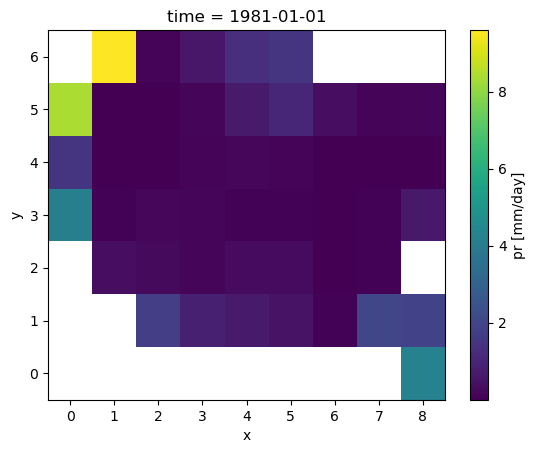

In [516]:
model_calib.sel(time="1981-01-01").plot()

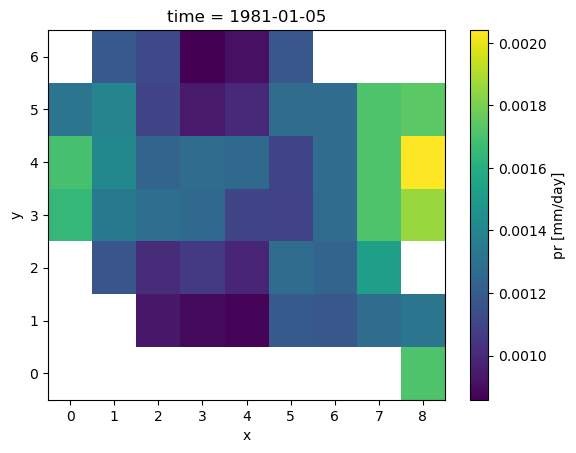

In [382]:
corrected_qdm.sel(time = '1981-01-05').plot()

In [814]:
corrected_with_extremes = corrected_with_extremes.sel(time=slice("1981-01-01", "2010-12-31"))

In [816]:
corrected_qdm = corrected_qdm.sel(time=slice("1981-01-01", "2010-12-31"))

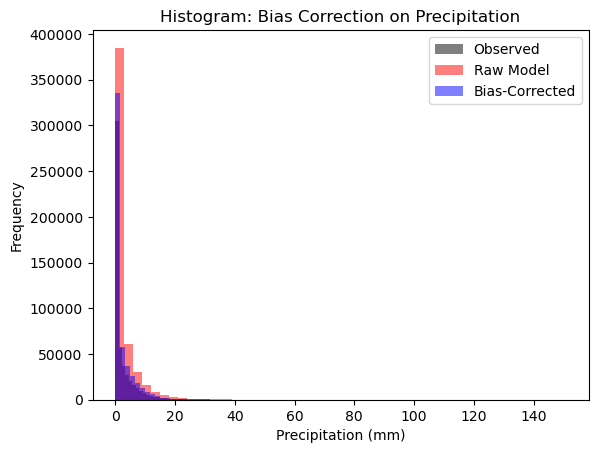

In [818]:
plt.hist(obs_calib_adj.values.flatten(), bins=50, alpha=0.5, label="Observed", color="black")
plt.hist(model_calib.values.flatten(), bins=50, alpha=0.5, label="Raw Model", color="red")
plt.hist(corrected_with_extremes.values.flatten(), bins=50, alpha=0.5, label="Bias-Corrected", color="blue")


plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram: Bias Correction on Precipitation")
plt.show()


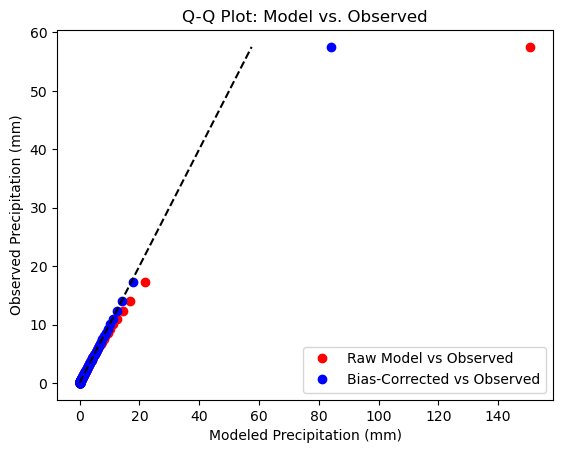

In [820]:
# Flatten DataArrays to 1D NumPy arrays
model_q = np.nanquantile(model_calib.values.flatten(), np.linspace(0, 1, 100))
corrected_q = np.nanquantile(corrected_with_extremes.sel(time=slice("1981-01-01", "2010-12-31")).values.flatten(), np.linspace(0, 1, 100))
obs_q = np.nanquantile(obs_calib_adj.values.flatten(), np.linspace(0, 1, 100))

# Plot Q-Q comparison
plt.plot(model_q, obs_q, "ro", label="Raw Model vs Observed")
plt.plot(corrected_q, obs_q, "bo", label="Bias-Corrected vs Observed")
plt.plot([min(obs_q), max(obs_q)], [min(obs_q), max(obs_q)], "k--")  # 1:1 line

plt.xlabel("Modeled Precipitation (mm)")
plt.ylabel("Observed Precipitation (mm)")
plt.legend()
plt.title("Q-Q Plot: Model vs. Observed"),
plt.show()

In [356]:
sns.kdeplot(model_calib.values.flatten(), label="Raw Model", color="red", linestyle ="dashed")
sns.kdeplot(obs_calib_adj.values.flatten(), label="Observed", color="black")
sns.kdeplot(corrected_qdm.sel(time=slice("1981-01-01", "2010-12-31")).values.flatten(), label="Bias-Corrected", color="blue")

plt.xlabel("Precipitation (mm)")
plt.ylabel("Density")
plt.legend()
plt.title("PDF: Bias Correction")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

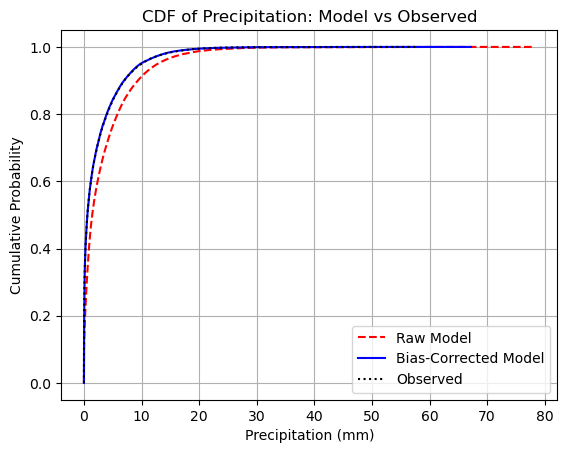

In [126]:
# Flatten DataArrays to 1D NumPy arrays (removing NaNs)
model_values = model_calib.values.flatten()
corrected_values = corrected_with_extremes.values.flatten()
obs_values = obs_calib_adj.values.flatten()

# Remove NaNs (if any)
model_values = model_values[~np.isnan(model_values)]
corrected_values = corrected_values[~np.isnan(corrected_values)]
obs_values = obs_values[~np.isnan(obs_values)]

# Compute CDFs
sorted_model = np.sort(model_values)
sorted_corrected = np.sort(corrected_values)
sorted_obs = np.sort(obs_values)

cdf_model = np.linspace(0, 1, len(sorted_model))
cdf_corrected = np.linspace(0, 1, len(sorted_corrected))
cdf_obs = np.linspace(0, 1, len(sorted_obs))

# Plot CDFs
plt.plot(sorted_model, cdf_model, label="Raw Model", linestyle="dashed", color="red")
plt.plot(sorted_corrected, cdf_corrected, label="Bias-Corrected Model", linestyle="solid", color="blue")
plt.plot(sorted_obs, cdf_obs, label="Observed", linestyle="dotted", color="black")

# Labels and legend
plt.xlabel("Precipitation (mm)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Precipitation: Model vs Observed")
plt.legend()
plt.grid()